# Disciple - 取引シミュレーション（Jupyter用）

In [1]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import load_setting
from funcs.tide import get_date_dir_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [2]:
res = AppRes()

excel = "ticks_20260116.xlsx"
code = "7011"
# code = "7203"
# code = "8306"
dict_setting = load_setting(res, code)
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
TURBULENCE = dict_setting["TURBULENCE"]
date_str = get_date_dir_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026/01/16
パラメータ
PERIOD_WARMUP : 180
PERIOD_MA_1 : 170
PERIOD_MA_2 : 500
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.05
PERIOD_RR : 30
TURBULENCE : 35.0
LOSSCUT_1 : -25
THRESHOLD_PM_MIN : 17.5
THRESHOLD_DDR_MIN : 0.4


In [3]:
# 取引明細
df_transaction = app.getTransaction()
df_transaction["累積損益"] = df_transaction["損益"].fillna(0).cumsum()
print("取引明細")
print(df_transaction)
print(df_transaction["注文日時"].dtype)
print(df_transaction["累積損益"].dtype)

list_html = conv_transaction_df2html(df_transaction)

output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_transaction.html")
print(output)
with open(output, mode="w") as f:
    f.write("\n".join(list_html))

list_trans = df_transaction["注文日時"]
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
    注文番号                          注文日時 銘柄コード  売買  約定単価  約定数量      損益 備考  \
0      1 2026-01-16 09:04:30.803045034  7011  売建  4734   100     NaN      
1      2 2026-01-16 09:08:11.567831039  7011  買埋  4721   100  1300.0      
2      3 2026-01-16 09:12:15.370083094  7011  買建  4742   100     NaN      
3      4 2026-01-16 09:19:36.396594048  7011  売埋  4731   100 -1100.0      
4      5 2026-01-16 09:19:37.402237892  7011  売建  4731   100     NaN      
5      6 2026-01-16 09:26:40.820658922  7011  買埋  4721   100  1000.0      
6      7 2026-01-16 09:27:56.070188999  7011  買建  4738   100     NaN      
7      8 2026-01-16 09:34:26.251421928  7011  売埋  4728   100 -1000.0      
8      9 2026-01-16 09:34:27.257245064  7011  売建  4728   100     NaN      
9     10 2026-01-16 09:51:31.241568089  7011  買埋  4691   100  3700.0      
10    11 2026-01-16 09:56:08.119432926  7011  売建  4675   100     NaN      
11    12 2026-01-16 10:02:09.259731054  7011  買埋  4685   100 -1000.0      
12    13 2026-01-16 

In [4]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [5]:
"""
累積損益のトレンドを作成するための準備
"""

# 元データ
ts = df_transaction["注文日時"]
pl = df_transaction["累積損益"]

# 日付（年月日）だけ取り出す
date = ts.iloc[0].normalize()

# 追加する先頭と末尾の行
start_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=9)],
        "累積損益": [0.0],
    }
)

end_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=15, minutes=30)],
        "累積損益": [pl.iloc[-1]],
    }
)

# トレンド用 DataFrame を作成
trend_df = pd.concat(
    [start_row, df_transaction[["注文日時", "累積損益"]], end_row], ignore_index=True
)

# 注文日時を index にした Series を作成
trend_series = trend_df.set_index("注文日時")["累積損益"]
trend_series

注文日時
2026-01-16 09:00:00.000000000       0.0
2026-01-16 09:04:30.803045034       0.0
2026-01-16 09:08:11.567831039    1300.0
2026-01-16 09:12:15.370083094    1300.0
2026-01-16 09:19:36.396594048     200.0
2026-01-16 09:19:37.402237892     200.0
2026-01-16 09:26:40.820658922    1200.0
2026-01-16 09:27:56.070188999    1200.0
2026-01-16 09:34:26.251421928     200.0
2026-01-16 09:34:27.257245064     200.0
2026-01-16 09:51:31.241568089    3900.0
2026-01-16 09:56:08.119432926    3900.0
2026-01-16 10:02:09.259731054    2900.0
2026-01-16 10:02:10.268480062    2900.0
2026-01-16 10:10:24.776307106    4200.0
2026-01-16 10:14:02.514441967    4200.0
2026-01-16 10:37:19.493143082    6700.0
2026-01-16 10:37:20.512698889    6700.0
2026-01-16 10:48:27.333925962    6900.0
2026-01-16 12:58:04.964831114    6900.0
2026-01-16 13:00:33.636852980    6100.0
2026-01-16 13:00:34.642779112    6100.0
2026-01-16 13:04:23.381340981    5300.0
2026-01-16 13:16:50.674288034    5300.0
2026-01-16 13:33:00.004383087    60

output/2026/01/16/7011_trend_profit.png


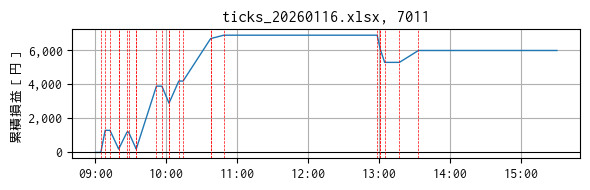

In [6]:
# 累積損益トレンド
fig, ax = plt.subplots(figsize=(6, 2))

ax.set_title(f"{excel}, {code}")
ax.plot(trend_series, linewidth=1)
ax.axhline(y=0, color="black", linewidth=0.75)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("累積損益［円］")
for t in list_trans:
    ax.axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)
ax.grid()

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_profit.png")
print(output)
plt.savefig(output)
plt.show()

In [7]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts  price          ma1          ma2    slope1  \
2026-01-16 09:00:04  1.768522e+09   4756  4756.000000  4756.000000  0.000000   
2026-01-16 09:00:05  1.768522e+09   4756  4756.000000  4756.000000  0.000000   
2026-01-16 09:00:06  1.768522e+09   4770  4760.666667  4760.666667  2.800000   
2026-01-16 09:00:07  1.768522e+09   4770  4763.000000  4763.000000  2.666667   
2026-01-16 09:00:08  1.768522e+09   4758  4762.000000  4762.000000  1.455556   
...                           ...    ...          ...          ...       ...   
2026-01-16 15:24:45  1.768545e+09   4670  4667.123529  4665.882000  0.013725   
2026-01-16 15:24:46  1.768545e+09   4670  4667.141176  4665.894000  0.015490   
2026-01-16 15:24:47  1.768545e+09   4668  4667.147059  4665.902000  0.012941   
2026-01-16 15:24:48  1.768545e+09   4668  4667.152941  4665.910000  0.010196   
2026-01-16 15:24:49  1.768545e+09   4667  4667.152941  4665.916000  0.005490   

                     rr  profit

In [8]:
df_tech["slope1"].describe()

count    19427.000000
mean         0.032200
std          0.050452
min          0.000000
25%          0.009608
50%          0.021569
75%          0.041176
max          2.800000
Name: slope1, dtype: float64

output/2026/01/16/7011_trend_technical.png


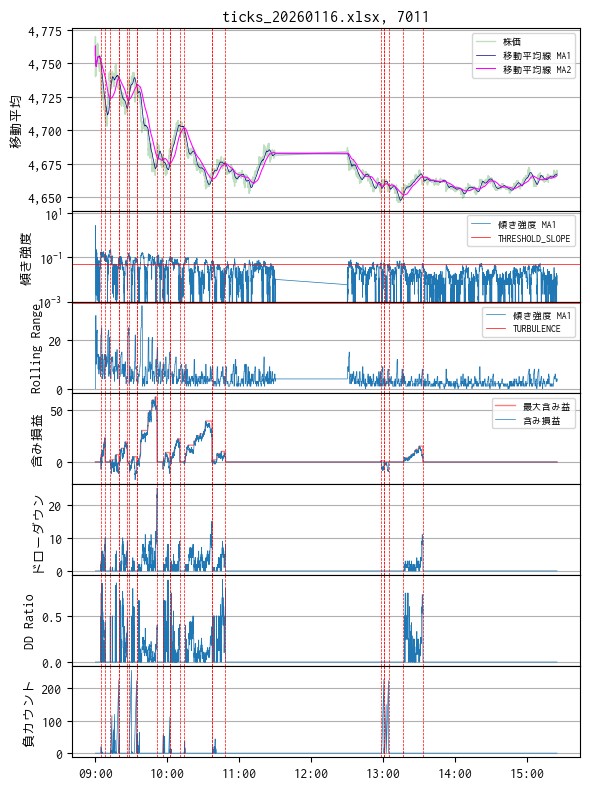

In [9]:
fig = plt.figure(figsize=(6, 8))
n = 7
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["price"], linewidth=1, color="green", alpha=0.25, label="株価")
ax[0].plot(df_tech["ma1"], linewidth=0.5, color="darkblue", label="移動平均線 MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="移動平均線 MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["slope1"], linewidth=0.5, label="傾き強度 MA1")
ax[1].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.5, label="THRESHOLD_SLOPE")
ax[1].set_yscale("log")
ax[1].set_ylabel("傾き強度")
ax[1].legend(fontsize=7)
_, y_high = ax[1].get_ylim()
ax[1].set_ylim(0.001, y_high)

ax[2].plot(df_tech["rr"], linewidth=0.5, label="傾き強度 MA1")
ax[2].axhline(y=TURBULENCE, color="red", linewidth=0.5, label="TURBULENCE")
ax[2].set_ylabel("Rolling Range")
ax[2].legend(fontsize=7)

ax[3].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[3].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[3].set_ylabel("含み損益")
ax[3].legend(fontsize=7)

ax[4].plot(df_tech["drawdown"], linewidth=0.5)
ax[4].set_ylabel("ドローダウン")

ax[5].plot(df_tech["dd_ratio"], linewidth=0.5)
ax[5].set_ylabel("DD Ratio")

ax[6].plot(df_tech["n_minus"], linewidth=0.5)
ax[6].set_ylabel("負カウント")

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_technical.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/16/7011_hist_slope.png


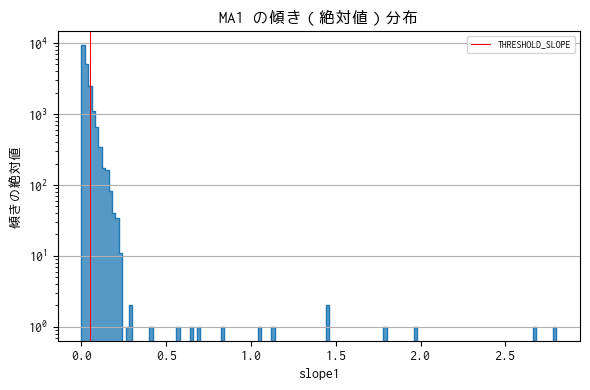

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("MA1 の傾き（絶対値）分布")
sns.histplot(data=df_tech, x="slope1", bins="sqrt", element="step")
ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
ax.set_yscale("log")
ax.set_ylabel("傾きの絶対値")
ax.grid(axis="y")
ax.legend(fontsize=7)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_hist_slope.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/16/7011_hist_rr.png


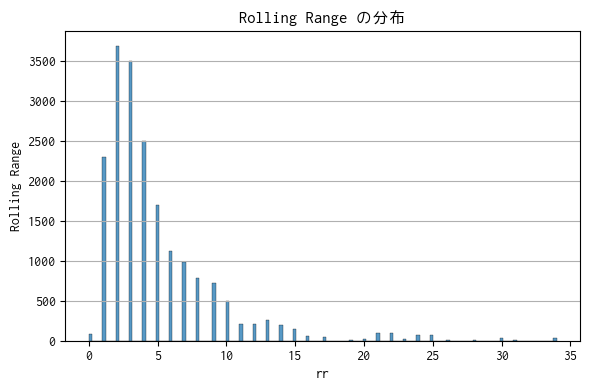

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Rolling Range の分布")
sns.histplot(data=df_tech, x="rr", bins="sqrt")
# ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
# ax.set_yscale("log")
ax.set_ylabel("Rolling Range")
ax.grid(axis="y")
# ax.legend(fontsize=7)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_hist_rr.png")
print(output)
plt.savefig(output)
plt.show()

In [12]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  乱高下  ロス1  利確1   建玉
2026-01-16 09:00:04    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 09:00:05    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 09:00:06    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 09:00:07    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 09:00:08    0.0    0.0  0.0  0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...  ...  ...
2026-01-16 15:24:45    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 15:24:46    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 15:24:47    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 15:24:48    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 15:24:49    0.0    0.0  0.0  0.0  0.0  0.0  0.0

[19427 rows x 7 columns]


output/2026/01/16/7011_trend_obs.png


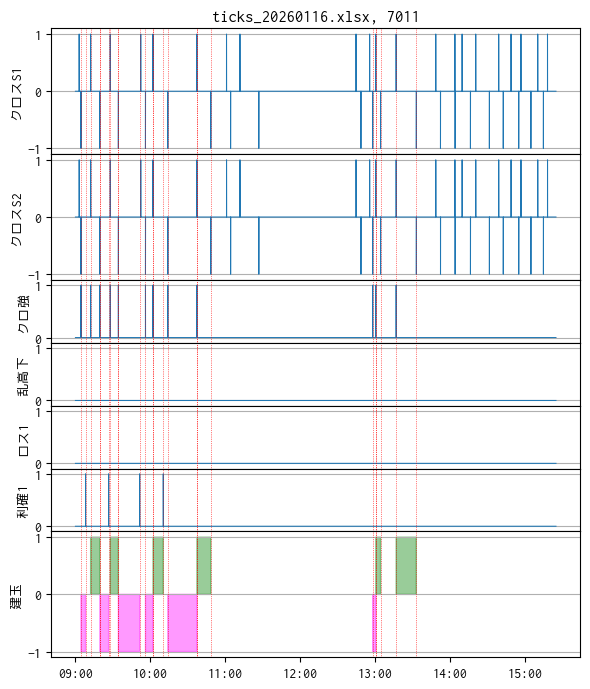

In [13]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()

targets = {"クロスS1", "クロスS2", "建玉"}
list_height_ratio = [2 if col in targets else 1 for col in df_obs.columns]
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=list_height_ratio)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")

special_cross = {"クロスS1", "クロスS2"}

for i, colname in enumerate(df_obs.columns):
    ax_i = ax[i]

    if colname in special_cross:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-1.1, 1.1)

    elif colname == "建玉":
        x = df_obs.index
        y = df_obs[colname]
        ax_i.fill_between(
            x, 0, y, where=y > 0, color="green", alpha=0.4, interpolate=True
        )
        ax_i.fill_between(
            x, 0, y, where=y < 0, color="magenta", alpha=0.4, interpolate=True
        )
        ax_i.set_ylim(-1.1, 1.1)

    else:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-0.1, 1.1)

    ax_i.set_ylabel(colname)
    ax_i.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_obs.png")
print(output)
plt.tight_layout()
plt.savefig(output)
plt.show()